## Import useful libraries

In [62]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import scipy.fftpack

## Load the data form excel file and sort by date

In [2]:
try:
    file = r'C:\Users\mb22\OneDrive\PhD\Quasar Shared\Data\Outputs\LongTermOutput\GuildfordOPall.xlsx'
    data = pd.read_excel(file).sort_values(by='date')
    print('NPL Laptop')
except:
    file = r'C:\Users\Matt\OneDrive\PhD\Quasar Shared\Data\Outputs\LongTermOutput\GuildfordOPall.xlsx'
    data = pd.read_excel(file).sort_values(by='date')
    print('Matts Surface')
data.head(3)

NPL Laptop


,linac_id,linac_name,install_year,name,full_date,date,device,type,energy,r1,r2,r3,rmean,temp,press,rcorr,rstd,op,comments
16276,3,LA3,2006,LA3 (2006),2012-11-01,2012-11-01,L00499,Linacheck,15MV,0.836,0.834,0.834,0.834667,26.1,726.5,0.834667,0.828,0.805153,NaN
14220,2,LA2,2010,LA2 (2010),2012-11-01,2012-11-01,L00597,Linacheck,20MeV,0.799,0.8,0.8,0.799667,23.7,726.5,0.799667,0.797,0.334588,NaN
14219,2,LA2,2010,LA2 (2010),2012-11-01,2012-11-01,L00597,Linacheck,16MeV,0.784,0.784,0.785,0.784333,23.7,726.5,0.784333,0.785,-0.084926,NaN


## FFT as done in paper?
- is this even useful...?

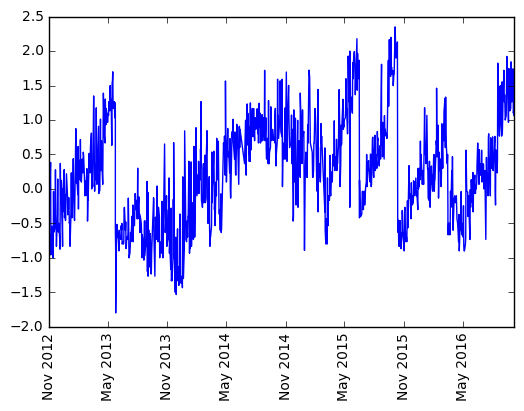

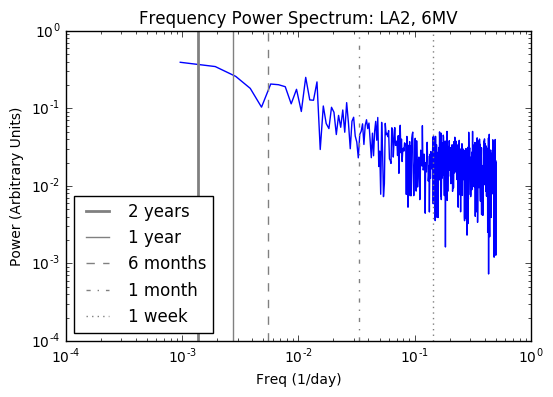

In [81]:
testlinac='LA2'
testenergy='6MV'
test_data=data[(data['linac_name']==testlinac) & (data['energy']==testenergy)]
plt.plot(test_data['date'],test_data['op'])
plt.xticks(rotation=90)
plt.show()

x = test_data['date'].values
y = test_data['op'].values
# sample spacing
T = 1
# Number of samplepoints
N = len(x)

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.loglog(xf, 2.0/N * np.abs(yf[:N//2]))

ax.axvline(0.5/365,label='2 years',c='grey', ls='-',lw=2)
ax.axvline(1/365,label='1 year',c='grey', ls='-')
ax.axvline(2/365,label='6 months',c='grey', ls='--')
ax.axvline(1/30,label='1 month',c='grey', ls='-.')
ax.axvline(1/7,label='1 week',c='grey', ls=':')
## plot 1/f power law....? Had to edit values to match the plot
#xs = [0.5,0.0005]
#ys = [0.001/xs[0],0.001/xs[1]]
#ax.plot(xs,ys,c='green')
plt.title('Frequency Power Spectrum: ' + str(testlinac) + ', ' + str(testenergy))
plt.xlabel('Freq (1/day)')
plt.ylabel('Power (Arbitrary Units)')
plt.legend(loc='lower left')

plt.show()

## Produce plots for each linac separated by energy

['LA5']
['6MV', '10MV']


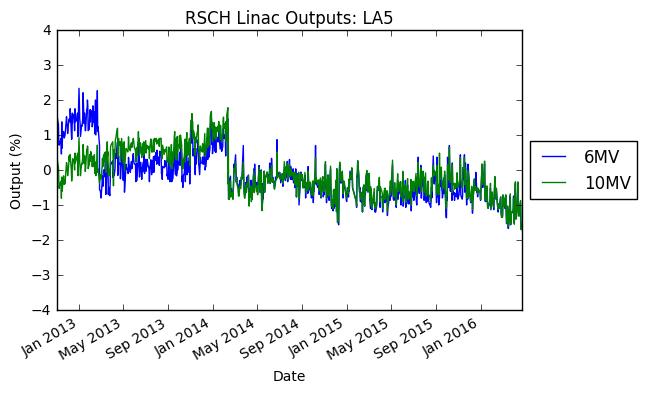

In [82]:
## list of each linac and energy to get the seperate data from
linacs = sorted(data.linac_name.unique())
linacs = ['LA5']
print(linacs)
energies = sorted(data.energy.unique())
energies=['6MV','10MV']
print(energies)

## plot in this way to format dates better (http://matplotlib.org/users/recipes.html)
for linac in linacs:
    fig, ax = plt.subplots(1)

    for energy in energies:
        energy_data = data[(data['linac_name']==linac) & (data['energy']==energy)]
        ax.plot(energy_data['date'],energy_data['op'],label=energy)

    fig.autofmt_xdate()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Date')
    ax.set_ylabel('Output (%)')
    ax.set_ylim(-4,4)
    #ax.set_xlim('01-Jan-2012','01-Jan-2017')
    ax.set_title('RSCH Linac Outputs: ' + linac)
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

## Compare 6MV with other energies
- Use process devised previosuly to remove non-matching date data, however now data is in a different (simpler) format.
- Ideally create a function which can accept the `linac`, `e1 = 6MV` and `e2 = other energy`. Also allows filtering a date range.
    - this should return the required data as 2 pandas dfs for use
    - Can then use the returned data to perform plotting and further analysis

### Function to extract mathcing data from 2 energies for a specific linac within a specified date range

In [83]:
def comp_op_energies(df,linac,e1,e2, d_start = '01-Jan-2000', d_end = '01-Jan-2100'):
    ## get only e1 and e2 energies for comparison for specific linac
    #df_linac_e1_e2 = df[(df['linac_name']==linac) & ((df['energy']==e1) | (df['energy']==e2))]
    
    ## remove 'NaT' values from dates (shouldnt need to do this for the Guildford data)
    df = df[pd.notnull(df['date']) & (df['date'] >=d_start) & (df['date']<=d_end)]
    
    ## split into different energies for the specified linac
    df_linac_e1 = df[(df['linac_name']==linac) & (df['energy']==e1)]
    df_linac_e2 = df[(df['linac_name']==linac) & (df['energy']==e2)]
    
    a1=df_linac_e1
    a2=df_linac_e2
    
    ## filtered to remove duplicated dates (default is that only the first occurance is kept)
    df_linac_e1 = df_linac_e1.drop_duplicates(subset=['date'])
    df_linac_e2 = df_linac_e2.drop_duplicates(subset=['date'])
    
    ## fiter to only contain dates that exist for both energies
    df_linac_e1 = df_linac_e1[df_linac_e1['date'].isin(df_linac_e2['date'])]
    df_linac_e2 = df_linac_e2[df_linac_e2['date'].isin(df_linac_e1['date'])]
    
    return df_linac_e1, df_linac_e2, linac, e1, e2, d_start, d_end

## Function to produce histogrsm showing rolling gradient of 2 energies

In [84]:
def comp_op_energies_grad_hist(df,linac,e1,e2, d_start = '01-Jan-2000', d_end = '01-Jan-2100',period=7):
    ## get only e1 and e2 energies for comparison for specific linac
    #df_linac_e1_e2 = df[(df['linac_name']==linac) & ((df['energy']==e1) | (df['energy']==e2))]
    
    ## remove 'NaT' values from dates (shouldnt need to do this for the Guildford data)
    df = df[pd.notnull(df['date']) & (df['date'] >=d_start) & (df['date']<=d_end)]
    
    ## split into different energies for the specified linac
    df_linac_e1 = df[(df['linac_name']==linac) & (df['energy']==e1)]
    df_linac_e2 = df[(df['linac_name']==linac) & (df['energy']==e2)]
    
    a1=df_linac_e1
    a2=df_linac_e2
    
    ## filtered to remove duplicated dates (default is that only the first occurance is kept)
    df_linac_e1 = df_linac_e1.drop_duplicates(subset=['date'])
    df_linac_e2 = df_linac_e2.drop_duplicates(subset=['date'])
    
    ## fiter to only contain dates that exist for both energies
    df_linac_e1 = df_linac_e1[df_linac_e1['date'].isin(df_linac_e2['date'])]
    df_linac_e2 = df_linac_e2[df_linac_e2['date'].isin(df_linac_e1['date'])]
    
    ## use the histogram function to get a histrogram of rolling gradient for the set period
    hist_grad_fig,hist_grad_mean,hist_grad_median,hist_grad_data=rolling_grad_hist(x=df_linac_e1['date'],
                                                                                   y=(np.array(df_linac_e1['op'])-np.array(df_linac_e2['op'])),
                                                                                   period=period)
    print(hist_grad_mean)
    
    return df_linac_e1, df_linac_e2, linac, e1, e2, d_start, d_end, period, hist_grad_fig,hist_grad_mean,hist_grad_median,hist_grad_data

0.00101876981252
0.00066573052033
-0.000880806422067
-0.00119312936047
-0.00130541943419
-0.000406153103472
-0.000528056289589
0.000569086550839
[0.0010187698125167697, 0.00066573052033036876, -0.00088080642206709832, -0.0011931293604698927, -0.0013054194341855707, -0.00040615310347248972, -0.00052805628958875201, 0.00056908655083914058]


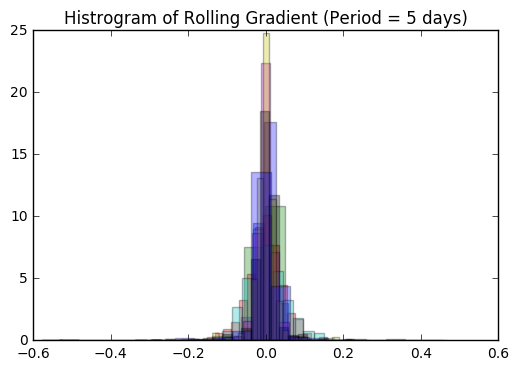

In [88]:
linacs=['LA1','LA2','LA3','LA4','LA5','LA6','RedA','RedB']
mean_grads = []
median_grads = []
for linac in linacs:
    if (linac == 'LA3') or (linac == 'LA4'):
        test1=comp_op_energies_grad_hist(data,linac,'6MV','15MV',d_start = '01-Jan-2000', d_end = '01-Jan-2100',period=5)
    else:
        test1=comp_op_energies_grad_hist(data,linac,'6MV','10MV',d_start = '01-Jan-2000', d_end = '01-Jan-2100',period=5)
    mean_grads.append(test1[9])
    median_grads.append(test1[10])
print(mean_grads)

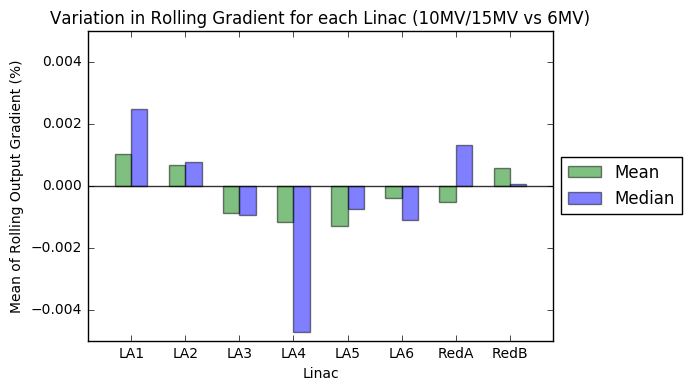

In [89]:
## plot data for all Guildford linacs

bwidth=0.3
psn1 = [i for i in range(len(linacs))]
psn2 = [i+bwidth for i in range(len(linacs))]
plt.bar(psn1,mean_grads,color='green',width=bwidth,alpha=0.5,label='Mean')
plt.bar(psn2,median_grads,color='blue',width=bwidth,alpha=0.5,label='Median')
plt.xticks(psn2,linacs)
plt.xlim(min(psn1)-0.5,max(psn2)+0.5+bwidth)
plt.ylim(-0.005,0.005)
plt.axhline(0,c='black',alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Variation in Rolling Gradient for each Linac (10MV/15MV vs 6MV)')
plt.ylabel('Mean of Rolling Output Gradient (%)')
plt.xlabel('Linac')


### Function to produce a plot of the energy comparison
- This uses the function above to determine the data to use.
- Results are returned as a dictionary.
- Can use matplotlib 'agg' backend if dont want to see plots...?

In [92]:
def comp_op_energies_plot(df,linac,e1,e2, d_start = '01-Jan-2000', d_end = '01-Jan-2100'):
    ## get the data using the created function
    df_e1,df_e2, linac, e1, e2, d_start, d_end = comp_op_energies(df=df,
                                                                  linac=linac,
                                                                  e1=e1,
                                                                  e2=e2,
                                                                  d_start=d_start,
                                                                  d_end=d_end)
    ## produce a plot
    fig, ax = plt.subplots(1,figsize=(5, 5))
    ax.plot([-5,5],[-5,5],c='grey',ls='--')
    ax.axhline(0,c='grey')
    ax.axvline(0,c='grey')
    ax.plot(df_e1['op'],df_e2['op'],marker='o',ms=3,ls='',alpha=0.5)
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_xlabel(e1)
    ax.set_ylabel(e2)
    plt.title('Output Comparison: ' + str(linac))
    
    return {'df_e1':df_e1,
            'df_e2':df_e2,
            'linac':linac,
            'e1':e1,
            'e2':e2,
            'd_start':d_start,
            'd_end':d_end,
            'fig':fig,
            }

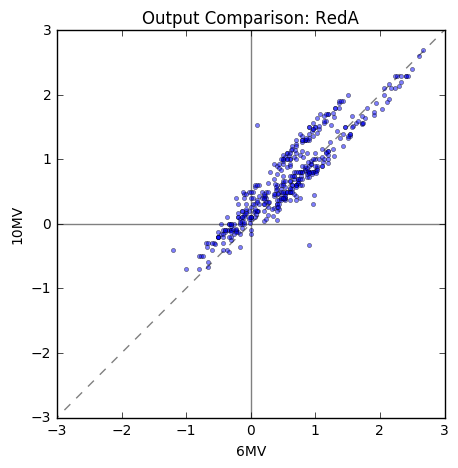

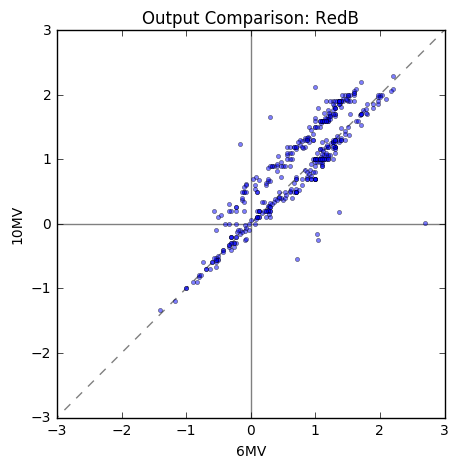

In [93]:
for abc in ['RedA','RedB']:
    a = comp_op_energies_plot(df=data,
                          linac=abc,
                          e1='6MV',
                          e2='10MV')

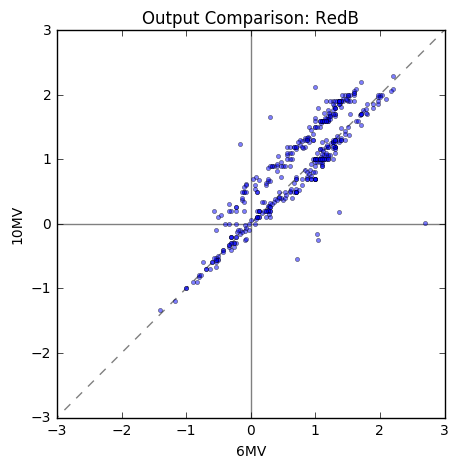

In [94]:
a['fig']

### Look at rolling correlation?

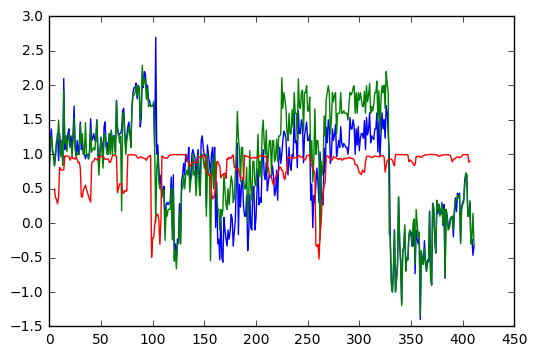

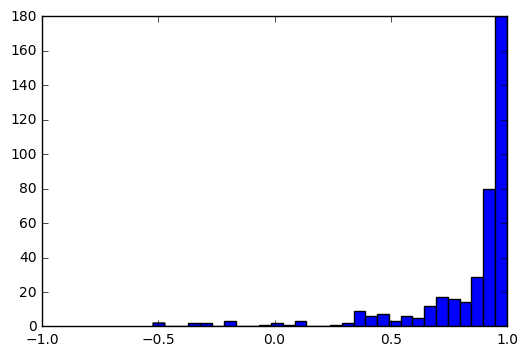

Rolling Correlation Mean: 0.8319731733514866


In [95]:
## get some data to test
df_e1,df_e2, linac, e1, e2, d_start, d_end = comp_op_energies(df=data,
                                                              linac='RedB',
                                                              e1='6MV',
                                                              e2='10MV',
                                                              )

## plot the data to check its correct
#plt.plot(df_e1['op'],df_e2['op'], marker='o', ls='',alpha=0.3)
## re_index the data for comparison purposes
a1 = df_e1['op'].reset_index(drop=True)
a2 = df_e2['op'].reset_index(drop=True)
## plot the output results
plt.plot(a1)
plt.plot(a2)

## calculate rolling correlation
roll_corr = a1.rolling(center=True,window=10).corr(a2)
plt.plot(roll_corr)
plt.show()

## histogram of the rolling_correlation values
plt.hist(roll_corr.dropna(),bins=30)
plt.xlim(-1,1)
plt.show()

## show mean of rolling corr
print('Rolling Correlation Mean:',roll_corr.mean())

## Rolling correlation may not tell me what I want
- If both energies are calibrated by the same amount, then it would not identify this.
- Does not identify points of calibration if both energies are calibrated by the same amount
    - Ideally want to identify the points of calibration for each energy individually.

## Identify calibration points by looking at the difference between the 2 energies
- If correlated the difference will remain constant and then there will be a step if they are calibrated by different amounts.
    - Note this will not identify a change if both energies are calibrated byt he same amount.
        - Although, maybe this isnt important for identifying if the energies follow each other?

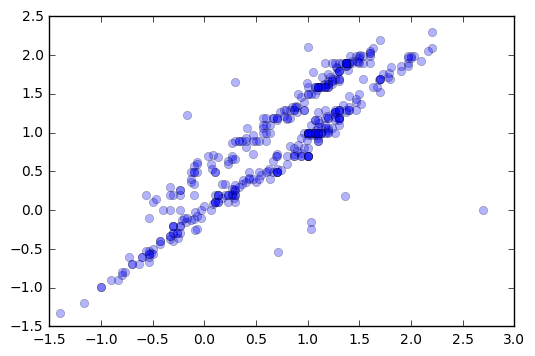

In [96]:
## check the data i am using is correct from earlier by doing a quick plot
plt.plot(df_e1['op'],df_e2['op'],marker='o',ls='',alpha=0.3)

## Start with plot of 2 outputs and plot of the difference

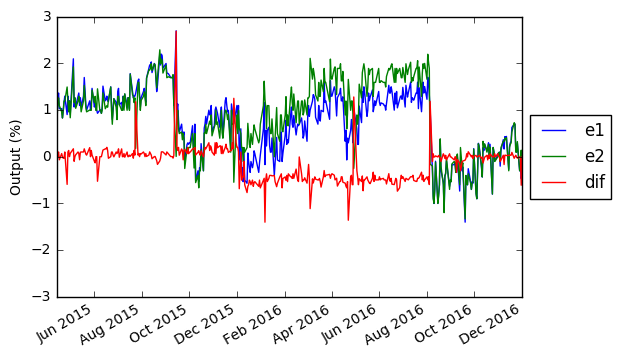

In [97]:
fig, ax = plt.subplots(1)
ax.plot(df_e1['date'],df_e1['op'],label='e1')
ax.plot(df_e2['date'],df_e2['op'],label='e2')
ax.plot(df_e1['date'],(np.array(df_e1['op'])-np.array(df_e2['op'])),label='dif')
fig.autofmt_xdate()
ax.set_ylim(-3,3)
ax.set_ylabel('Output (%)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Need to identify steps in data.
- Spikes should be ignored
- Rolling median of use?

## Look at the gradient of the differences to determine if this is centred around 0.
- This would indicate that the energies follow each other, rather than one changing faster than the other
- Look at a rolling gradient with a customisable period.
    - i.e. use date (convert to num days) and dif as the x and y and do a numpy polyfit

In [98]:
## get rolling linear fit from x and y data (x = date, y = dif b/w 2 energies)

def rolling_grad_hist(x,y,period):
    period = period ## rolling period in days

    ## need to first change x into number of days for use with np.polyfit
    minday = x.min()
    x_days=[]
    for i in x.index:
        ddif = (x[i]-minday).days
        x_days.append(ddif)

        ## plot of the data
    #plt.plot(x,y)
    #plt.plot(x_days,y)

    ## normal fit for all data
    all_fit_grads=[]
    for i in range(len(x_days)-period):
        start = i
        end = i+period
        fit_res = np.polyfit(x_days[start:end],y[start:end],deg=1)
        all_fit_grads.append(fit_res[0])
        #print(fit_res)
        fitx=[]
        fity=[]
        for i in [min(x_days[start:end]),max(x_days[start:end])]:
            theday = i
            thefit = fit_res[0]*theday + fit_res[1]
            fitx.append(theday)
            fity.append(thefit)
        #print(fitx)
        #print(fity)
        #plt.plot(fitx,fity) ## fitted data plotted after each step

    #plt.plot(x_days[start:end],y[start:end])
    #plt.plot(x_days,y) ## all data plotted
    ## plot histogram of different gradients - peak around 0 means energies follow each other.
    fig1 = plt.hist(all_fit_grads,bins=20,normed=True, alpha=0.3)
    plt.title('Histrogram of Rolling Gradient (Period = '+str(period)+' days)')
    grads_mean = np.mean(all_fit_grads)
    grads_median = np.median(all_fit_grads)
    grad_data = all_fit_grads
    return fig1,grads_mean,grads_median,grad_data

Mean: 0.000163355583999


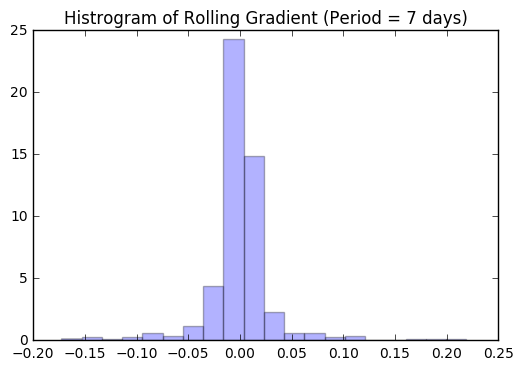

In [99]:
test=rolling_grad_hist(x=df_e1['date'],y=(np.array(df_e1['op'])-np.array(df_e2['op'])),period=7)
print('Mean:',test[1])

In [100]:
linacs=['LA5','LA6']
linacs

['LA5', 'LA6']